# Import Library

In [1]:
# ==== Standard library & umum ====
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

# ==== Model & algoritma ====
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# ==== Preprocessing & feature selection ====
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from imblearn.combine import SMOTEENN


# ==== Evaluasi & metrik ====
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)


# Load Dataset

In [2]:
# Import dataset Indian Liver Patient
liver_dataset = fetch_ucirepo(id=225)

X = liver_dataset.data.features
y = liver_dataset.data.targets

df = pd.concat([X,y], axis=1)

# Pre Processing 1

In [3]:
df['Selector'] = df['Selector'].replace({2:0})

## Drop Duplicate data and Missing Value

In [4]:
missing_value = df.isnull().sum()
print("Missing values per column:")
print(missing_value)


Missing values per column:
Age          0
Gender       0
TB           0
DB           0
Alkphos      0
Sgpt         0
Sgot         0
TP           0
ALB          0
A/G Ratio    4
Selector     0
dtype: int64


In [5]:
duplicated = df.duplicated().sum()
print(f"Duplicated Data : {duplicated}")

Duplicated Data : 13


In [6]:
df = df.drop_duplicates()
df = df.dropna()

In [7]:
df['Gender_Encoded'] = df['Gender'].map({'Female': 0, 'Male': 1})
df = df.drop(columns=['Gender'])

# EDA

In [8]:
df.head()

,Age,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Selector,Gender_Encoded
0,65,0.7,0.1,187,16,18,6.8,3.3,0.90,1,0
1,62,10.9,5.5,699,64,100,7.5,3.2,0.74,1,1
2,62,7.3,4.1,490,60,68,7.0,3.3,0.89,1,1
3,58,1.0,0.4,182,14,20,6.8,3.4,1.00,1,1
4,72,3.9,2.0,195,27,59,7.3,2.4,0.40,1,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 566 entries, 0 to 582
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             566 non-null    int64  
 1   TB              566 non-null    float64
 2   DB              566 non-null    float64
 3   Alkphos         566 non-null    int64  
 4   Sgpt            566 non-null    int64  
 5   Sgot            566 non-null    int64  
 6   TP              566 non-null    float64
 7   ALB             566 non-null    float64
 8   A/G Ratio       566 non-null    float64
 9   Selector        566 non-null    int64  
 10  Gender_Encoded  566 non-null    int64  
dtypes: float64(5), int64(6)
memory usage: 53.1 KB


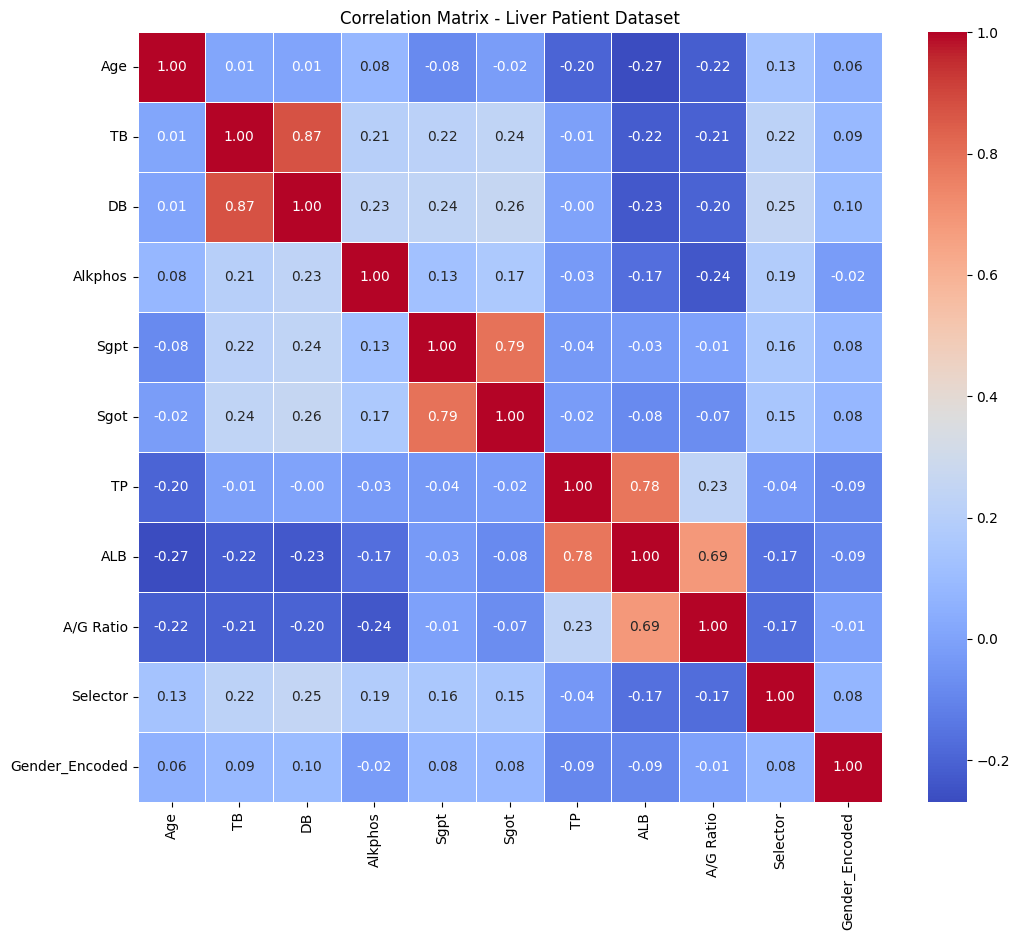

In [10]:
df_numeric = df.select_dtypes(include=[np.number])

# Hitung korelasi
correlation_matrix = df_numeric.corr()

# Plotting Heatmap
plt.figure(figsize=(12, 10)) 

sns.heatmap(correlation_matrix, 
            annot=True,      
            fmt=".2f",        
            cmap="coolwarm",  
            linewidths=0.5)   

plt.title("Correlation Matrix - Liver Patient Dataset")
plt.show()

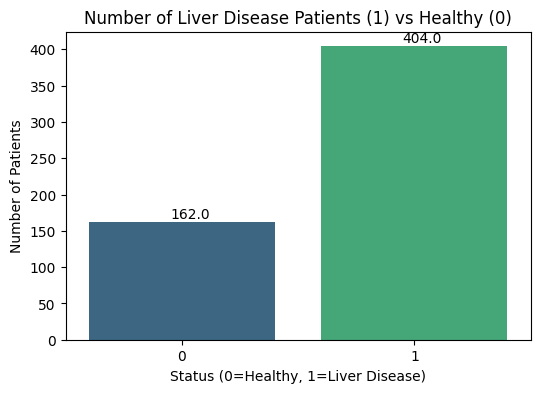

In [11]:
plt.figure(figsize=(6, 4))
# Using 'Selector' (0=Healthy, 1=Liver Disease)
ax = sns.countplot(x='Selector', data=df, palette='viridis')

plt.title('Number of Liver Disease Patients (1) vs Healthy (0)')
plt.xlabel('Status (0=Healthy, 1=Liver Disease)')
plt.ylabel('Number of Patients')

# Add value labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.35, p.get_height() + 5))

plt.show()


# Split 80:20

In [12]:
X = df.drop(columns=['Selector'])
y = df["Selector"]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Pre Processing 2

## Standarisasi


In [14]:
# Pilih Columns yg tidak ingin di standarisasi
cols_to_scale = [col for col in X_train.columns if col != 'Gender']

# Siapkan ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num',          RobustScaler(),    cols_to_scale)
    ],
    remainder='passthrough', 
    verbose_feature_names_out=False 
).set_output(transform="pandas") #

# Terapkan pada Data
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

print("Preview Data (Gender tidak berubah, yang lain berubah):")
print(X_train_scaled.head())

Preview Data (Gender tidak berubah, yang lain berubah):
          Age      TB   DB   Alkphos      Sgpt      Sgot        TP       ALB  \
114  0.192308  3.0000  2.7  3.713115  4.082759  4.179487 -0.641509 -0.727273   
398 -0.269231 -0.1250 -0.1  0.000000 -0.220690  0.162393  0.415094  0.545455   
194  0.153846  0.6250  0.3  0.008197  0.413793 -0.145299 -0.641509 -0.090909   
313 -0.576923 -0.1250 -0.1 -0.409836 -0.220690 -0.316239  1.018868  1.272727   
293 -0.846154  0.0625  0.2 -0.139344  0.110345  0.008547  0.867925  1.090909   

     A/G Ratio  Gender_Encoded  
114     -0.675             0.0  
398      0.150             0.0  
194      0.400             0.0  
313      0.900            -1.0  
293      0.650             0.0  


## Feature Selection RFE

In [15]:
n_features_to_select = 8  

base_estimator_rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rfe_rf = RFE(
    estimator=base_estimator_rf,
    n_features_to_select=n_features_to_select,
    step=1
)

rfe_rf.fit(X_train_scaled, y_train)

selected_mask_rf = rfe_rf.support_
selected_features_rf = X_train_scaled.columns[selected_mask_rf]

print("Fitur terpilih (RF + RFE)")
for f in selected_features_rf:
    print("-", f)

Fitur terpilih (RF + RFE)
- Age
- TB
- DB
- Alkphos
- Sgpt
- Sgot
- TP
- ALB


In [16]:
X_train_selected = X_train_scaled[selected_features_rf]
X_test_selected = X_test_scaled[selected_features_rf]

## Handling Imbalanced Data with SMOTEENN

In [17]:
smote_enn = SMOTEENN(random_state=42)
X_res_clean, y_res_clean = smote_enn.fit_resample(X_train_selected, y_train)

# Modelling

## MLP

In [18]:
mlp = MLPClassifier(
    max_iter=300,
    random_state=42,
    early_stopping=True
)

param_grid = {
    "hidden_layer_sizes": [(64,), (128,), (64, 32), (128, 64)],
    "activation": ["tanh", "relu"],
    "solver": ["adam", "sgd"],
    "alpha": [1e-4, 1e-3, 1e-2],
    "learning_rate_init": [0.001, 0.01]
}


In [19]:
grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=10,
    scoring="roc_auc",   
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_res_clean, y_res_clean)

print("Best ROC AUC (CV):", grid_search.best_score_)
print("Best params:", grid_search.best_params_)
best_mlp = grid_search.best_estimator_

y_proba = best_mlp.predict_proba(X_test_selected)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_proba)
print("Test ROC AUC:", test_roc_auc)


Fitting 10 folds for each of 96 candidates, totalling 960 fits
Best ROC AUC (CV): 0.9311496598639455
Best params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.01, 'solver': 'adam'}
Test ROC AUC: 0.8477366255144032


In [20]:
y_pred = best_mlp.predict(X_test_selected)

print(classification_report(y_test, y_pred))

y_proba = best_mlp.predict_proba(X_test_selected)[:, 1]
roc = roc_auc_score(y_test, y_proba)
print("Test ROC AUC:", roc)


              precision    recall  f1-score   support

           0       0.53      0.94      0.68        33
           1       0.96      0.67      0.79        81

    accuracy                           0.75       114
   macro avg       0.75      0.80      0.73       114
weighted avg       0.84      0.75      0.76       114

Test ROC AUC: 0.8477366255144032


Confusion matrix:
 [[31  2]
 [27 54]]


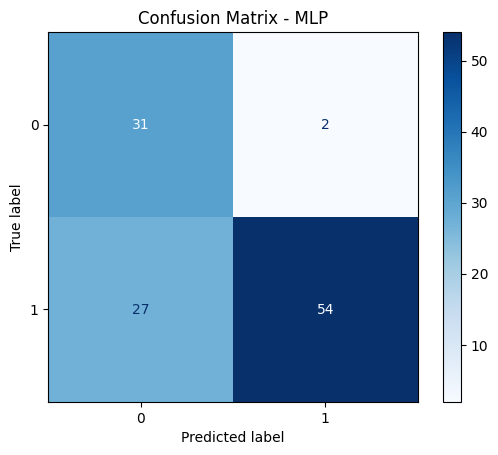

In [21]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - MLP")
plt.show()

In [22]:
print("Precision (weighted):", precision_score(y_test, y_pred, average="weighted"))
print("Recall (weighted)   :", recall_score(y_test, y_pred, average="weighted"))
print("F1-score (weighted) :", f1_score(y_test, y_pred, average="weighted"))

Precision (weighted): 0.8398690692247862
Recall (weighted)   : 0.7456140350877193
F1-score (weighted) : 0.7573467638776897


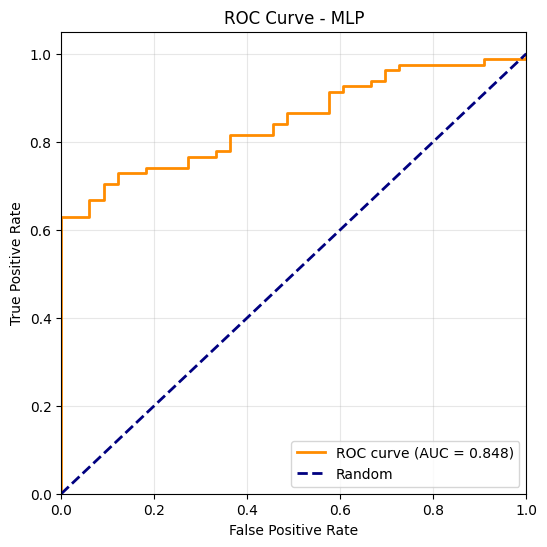

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="darkorange",
         lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - MLP")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## AdaBoost

In [24]:
base_tree = DecisionTreeClassifier(
    max_depth=1,         
    random_state=42
)

ada = AdaBoostClassifier(
    estimator=base_tree,  
    random_state=42
)

param_grid = {
    "n_estimators": [50, 100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.5, 1.0],
    "estimator__max_depth": [1, 2, 3]  
}

grid_search = GridSearchCV(
    estimator=ada,
    param_grid=param_grid,
    cv=10,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_res_clean, y_res_clean)

print("Best ROC AUC (CV):", grid_search.best_score_)
print("Best params:", grid_search.best_params_)
best_ada = grid_search.best_estimator_

y_proba = best_ada.predict_proba(X_test_selected)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_proba)
print("Test ROC AUC:", test_roc_auc)


Fitting 10 folds for each of 48 candidates, totalling 480 fits
Best ROC AUC (CV): 0.9831190476190474
Best params: {'estimator__max_depth': 3, 'learning_rate': 1.0, 'n_estimators': 300}
Test ROC AUC: 0.8237934904601572


In [25]:
y_pred = best_ada.predict(X_test_selected)

print(classification_report(y_test, y_pred))

y_proba = best_ada.predict_proba(X_test_selected)[:, 1]
roc = roc_auc_score(y_test, y_proba)
print("Test ROC AUC:", roc)


              precision    recall  f1-score   support

           0       0.50      0.73      0.59        33
           1       0.86      0.70      0.78        81

    accuracy                           0.71       114
   macro avg       0.68      0.72      0.68       114
weighted avg       0.76      0.71      0.72       114

Test ROC AUC: 0.8237934904601572


Confusion matrix:
 [[24  9]
 [24 57]]


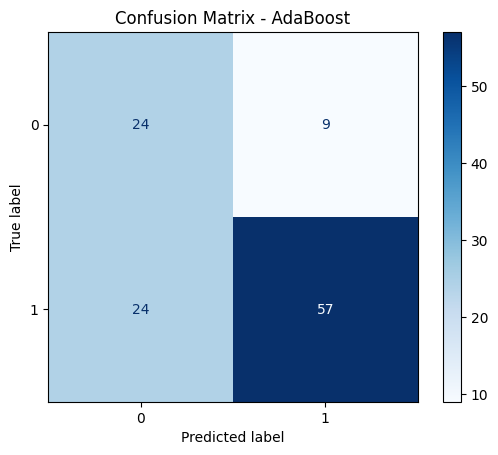

In [26]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - AdaBoost")
plt.show()

In [27]:
print("Precision (weighted):", precision_score(y_test, y_pred, average="weighted"))
print("Recall (weighted)   :", recall_score(y_test, y_pred, average="weighted"))
print("F1-score (weighted) :", f1_score(y_test, y_pred, average="weighted"))

Precision (weighted): 0.7583732057416268
Recall (weighted)   : 0.7105263157894737
F1-score (weighted) : 0.7225603691769106


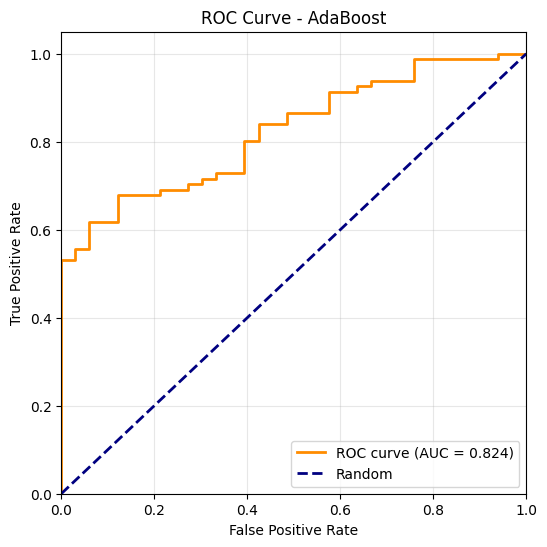

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="darkorange",
         lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - AdaBoost")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## CatBoost

In [29]:
cat = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    verbose=0,          # biar nggak spam log saat GridSearch
    random_state=42
)

param_grid = {
    "depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "iterations": [200, 400, 800],
    "l2_leaf_reg": [1, 3, 5]
}


In [30]:
grid_search = GridSearchCV(
    estimator=cat,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_res_clean, y_res_clean)

print("Best ROC AUC (CV):", grid_search.best_score_)
print("Best params:", grid_search.best_params_)

best_cat = grid_search.best_estimator_


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best ROC AUC (CV): 0.9868587047939444
Best params: {'depth': 8, 'iterations': 800, 'l2_leaf_reg': 1, 'learning_rate': 0.01}


In [31]:
# prediksi probabilitas untuk ROC AUC
y_proba = best_cat.predict_proba(X_test_selected)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_proba)
print("Test ROC AUC:", test_roc_auc)

# prediksi kelas + classification report
y_pred = best_cat.predict(X_test_selected)
print(classification_report(y_test, y_pred))


Test ROC AUC: 0.8256640478862701
              precision    recall  f1-score   support

           0       0.53      0.85      0.65        33
           1       0.92      0.69      0.79        81

    accuracy                           0.74       114
   macro avg       0.72      0.77      0.72       114
weighted avg       0.81      0.74      0.75       114



Confusion matrix:
 [[28  5]
 [25 56]]


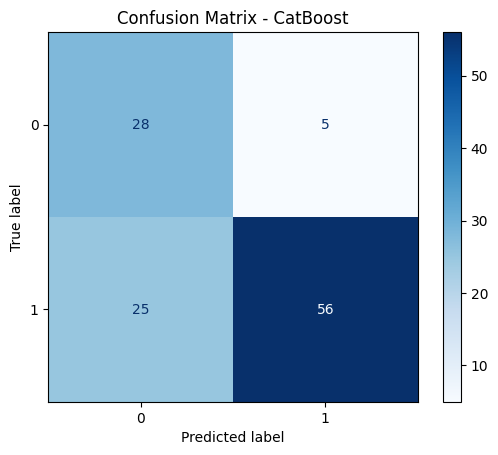

In [32]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - CatBoost")
plt.show()

In [33]:
print("Precision (weighted):", precision_score(y_test, y_pred, average="weighted"))
print("Recall (weighted)   :", recall_score(y_test, y_pred, average="weighted"))
print("F1-score (weighted) :", f1_score(y_test, y_pred, average="weighted"))

Precision (weighted): 0.8052159473847006
Recall (weighted)   : 0.7368421052631579
F1-score (weighted) : 0.748909614356888


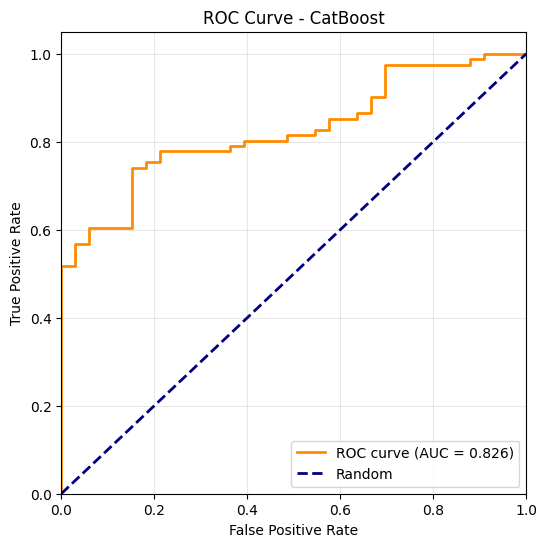

In [34]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="darkorange",
         lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CatBoost")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()